In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

def calculate_oxide_thickness(
    # Основные параметры процесса
    T,           # температура [°C]
    P,           # давление [атм]
    time,        # время [ч]
    orientation, # ориентация: '100', '110', '111'
    ambient,     # среда: 'dry' или 'wet'
    
    # Параметры легирования
    doping_type=None,  # 'p' или 'n'
    doping_conc=0,     # концентрация [см⁻³]
    N_ref=1e19,        # эталонная концентрация [см⁻³]
    
    # Начальные условия
    x0=0.002,          # начальная толщина [мкм]
    
    # Параметры модели для сухого кислорода
    B0_dry=7.72e2, Ea_B_dry=1.23,      # для B
    BA0_dry=6.23e6, Ea_BA_dry=2.00,    # для B/A
    exp_B_dry=1.0, exp_BA_dry=0.7,     # показатели степени для давления
    
    # Параметры модели для влажного кислорода  
    B0_wet=2.14e2, Ea_B_wet=0.71,      # для B
    BA0_wet=8.95e7, Ea_BA_wet=2.05,    # для B/A
    exp_B_wet=1.0, exp_BA_wet=0.5,     # показатели степени для давления
    
    # Коэффициенты ориентации
    K_100=1.0, K_110=1.45, K_111=1.68,
    
    # Коэффициенты легирования
    alpha_B=0.5, alpha_P=1.0
):
    """
    Расчёт толщины окисла по модели Дила-Гроува с параметризованными константами
    """
    
    # Константы
    k = 8.617e-5  # эВ/К
    
    # Температура в Кельвинах
    T_K = T + 273.15
    
    # Выбор параметров в зависимости от среды
    if ambient == 'dry':
        B0 = B0_dry
        Ea_B = Ea_B_dry
        BA0 = BA0_dry
        Ea_BA = Ea_BA_dry
        exp_B = exp_B_dry
        exp_BA = exp_BA_dry
    else:  # wet
        B0 = B0_wet
        Ea_B = Ea_B_wet
        BA0 = BA0_wet
        Ea_BA = Ea_BA_wet
        exp_B = exp_B_wet
        exp_BA = exp_BA_wet
    
    # Расчёт B с учётом температуры и давления
    B = B0 * np.exp(-Ea_B / (k * T_K)) * (P ** exp_B)
    
    # Расчёт B/A 
    orient_factors = {'100': K_100, '110': K_110, '111': K_111}
    BA = BA0 * np.exp(-Ea_BA / (k * T_K)) * (P ** exp_BA) * orient_factors[orientation]
    
    # Поправка на легирование
    if doping_type == 'p' and doping_conc > N_ref:
        B *= (1 + alpha_B * doping_conc / N_ref)
    elif doping_type == 'n' and doping_conc > N_ref:
        BA *= (1 + alpha_P * doping_conc / N_ref)
    
    # Параметр A
    A = B / BA
    
    # Поправка времени
    tau = (x0**2 + A * x0) / B
    
    # Решение уравнения Дила-Гроува
    x = (np.sqrt(A**2 + 4 * B * (time + tau)) - A) / 2
    
    return x, A, B, BA

# Пример использования с кастомными параметрами
thickness, A, B, BA = calculate_oxide_thickness(
    T=1000, P=1.0, time=2.0, 
    orientation='100', ambient='dry',
    doping_type='n', doping_conc=5e19,
    
    # Можно переопределить любые параметры модели:
    B0_dry=8.0e2,        # свой предекспоненциальный множитель
    Ea_B_dry=1.25,       # своя энергия активации
    K_111=1.70,          # свой коэффициент для ориентации (111)
    alpha_P=1.2          # свой коэффициент для фосфора
)

print( thickness)

def aaaaaaa(x): return True

0.12611690606740644


ФИНАЛЬНАЯ МОДЕЛЬ: ЯРКИЕ ЭФФЕКТЫ OED И ORD

ПРИМЕСЬ: B
ПАРАМЕТРЫ при 1273K (1000°C):
  D_i = 1.0e-05 см²/с
  C_i_eq = 1.0e+13 см⁻³
  D_v = 1.0e-06 см²/с
  C_v_eq = 1.0e+13 см⁻³
  K_R = 1.0e-23 см³/с
  B: D_eq=1.0e-15 см²/с, f=0.9
  B: D_eq=1.0e-15 см²/с, f=0.9
  Окисление: 0%-70%
  Целевое C_i/C_i_eq у поверхности: 10.0

СИМУЛЯЦИЯ B (f=0.9):
  Время: 180 с, шагов: 600
    t=0.0 с: Ci/Ci_eq=1.27, spread=0.000

РЕЗУЛЬТАТЫ для B (f=0.9):
  В области окисления:
    C_i/C_i_eq = 4.09
    C_v/C_v_eq = 0.64
    D_eff/D_eq = 3.75
  Под маской: D_eff/D_eq = 1.00
  → ЯВНЫЙ OED: усиление в 3.7 раз
  → ЧЕТКИЙ КОНТРАСТ между областями!


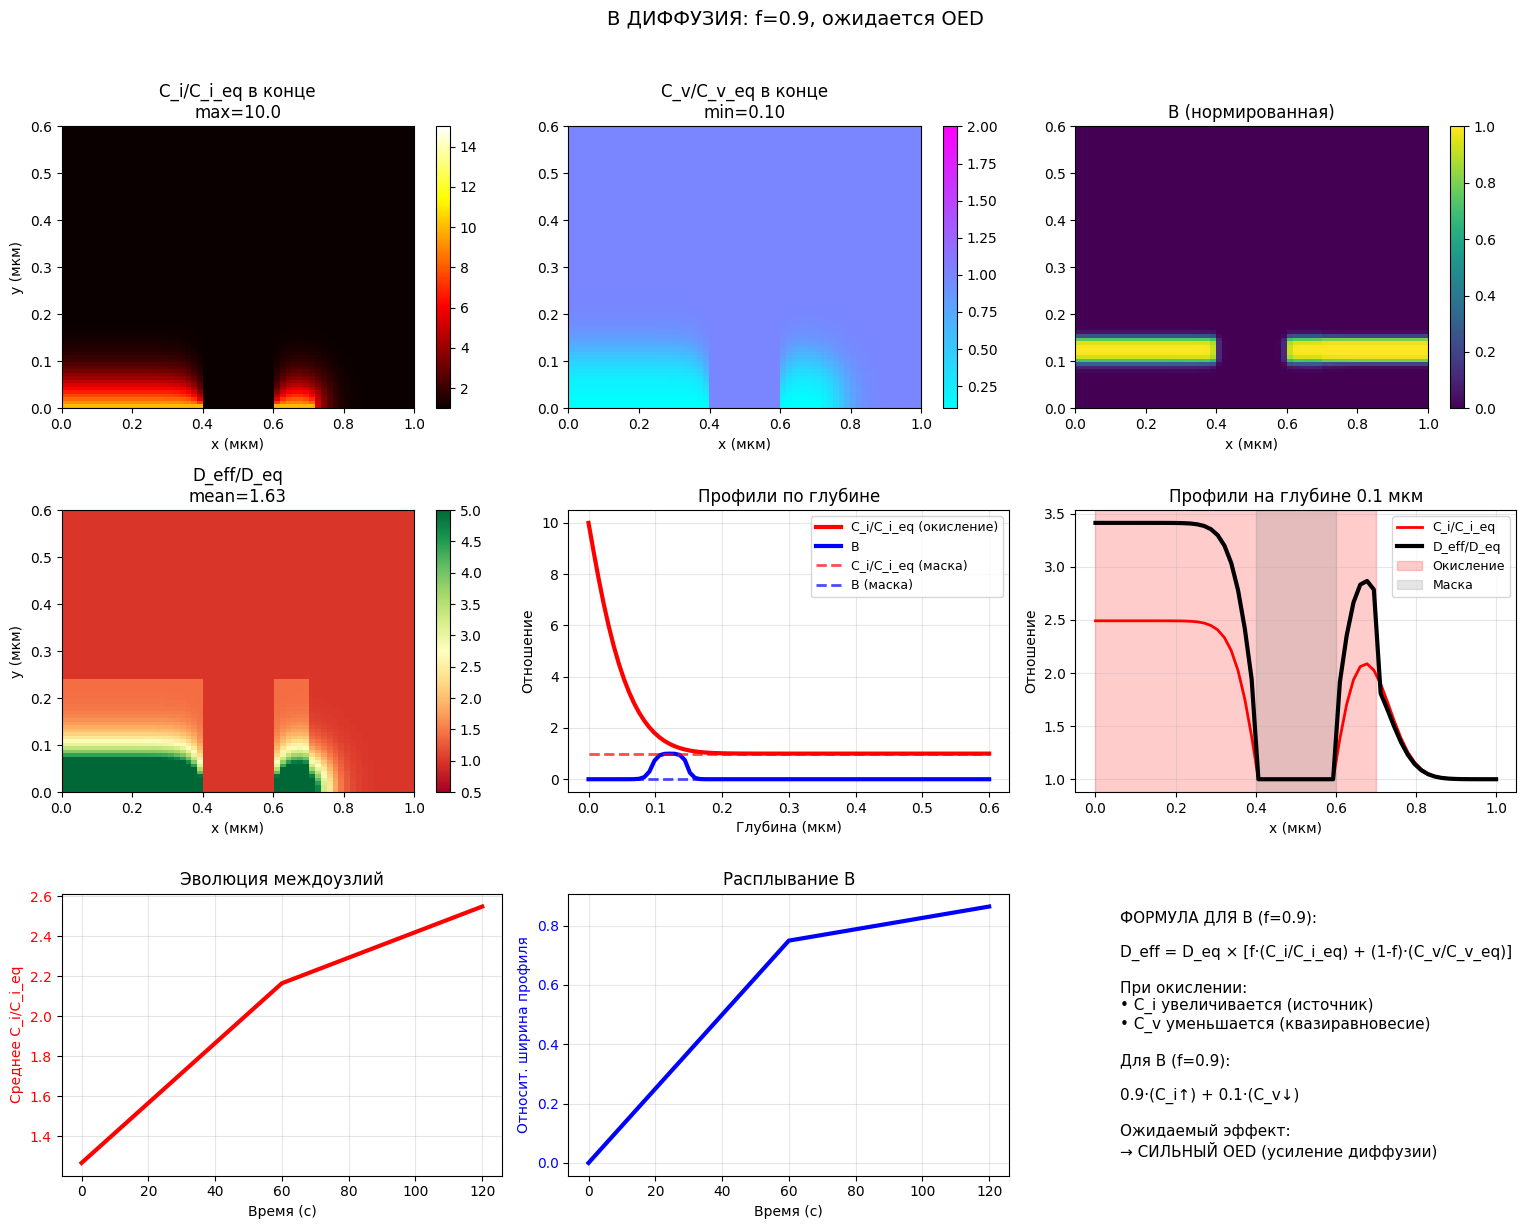


СВОДКА РЕЗУЛЬТАТОВ:

B (f=0.9):
  Под окислением: D_eff/D_eq = 3.75
  Под маской: D_eff/D_eq = 1.00
  → ЯВНЫЙ OED: усиление в 3.7 раз
  → КОНТРАСТ: в 3.7 раз больше под окислением!

ФИЗИЧЕСКАЯ ИНТЕРПРЕТАЦИЯ:
----------------------------------------------------------------------
Бор (f=0.9): 0.9·(C_i↑) + 0.1·(C_v↓) → сильное увеличение D_eff (OED)
Сурьма (f=0.1): 0.1·(C_i↑) + 0.9·(C_v↓) → уменьшение D_eff (ORD)
Фосфор (f=0.6): сбалансированный эффект


In [14]:
import numpy as np
import matplotlib.pyplot as plt

class FinalDiffusionModel:
    def __init__(self, nx=60, ny=80, Lx=1e-4, Ly=6e-5, T=1273):
        """
        ФИНАЛЬНАЯ корректная модель
        """
        self.nx, self.ny = nx, ny
        self.x = np.linspace(0, Lx, nx)
        self.y = np.linspace(0, Ly, ny)
        self.dx, self.dy = self.x[1]-self.x[0], self.y[1]-self.y[0]
        
        self.T = T
        self.kT = 8.617e-5 * T
        
        # ФИЗИЧЕСКИ ПРАВИЛЬНЫЕ ПАРАМЕТРЫ
        self.set_parameters()
        
        # Концентрации
        self.Ci = np.ones((ny, nx)) * self.Ci_eq
        self.Cv = np.ones((ny, nx)) * self.Cv_eq
        self.dopant = np.zeros((ny, nx))
        
        # Маска (нитрид в центре)
        self.mask = np.ones((ny, nx))
        mask_start = int(nx * 0.4)
        mask_end = int(nx * 0.6)
        self.mask[:, mask_start:mask_end] = 0  # 0 = под маской
        
        # Окисление
        self.oxidation_region = None
        self.g_i = np.zeros((ny, nx))
        
        # Примесь
        self.dopant_type = 'B'
        self.set_dopant_params()
        
        self.use_quasi_equilibrium = True
        
    def set_parameters(self):
        """
        РЕАЛИСТИЧНЫЕ параметры для сильного OED/ORD эффектов
        """
        # При 1000°C
        self.Di = 1e-5      # см²/с - диффузия междоузлий быстрая!
        self.Ci_eq = 1e13   # см⁻³ - равновесная концентрация
        
        # Вакансии - КЛЮЧЕВОЙ ПАРАМЕТР!
        self.Dv = 1e-6      # см²/с
        self.Cv_eq = 1e13   # см⁻³ - СОВПАДАЕТ с C_i_eq!
        
        # Константа рекомбинации (малая для медленной рекомбинации)
        self.KR = 1e-23     # см³/с
        
        # Произведение для квазиравновесия
        self.CiCv_eq = self.Ci_eq * self.Cv_eq
        
        print(f"ПАРАМЕТРЫ при {self.T}K ({self.T-273:.0f}°C):")
        print(f"  D_i = {self.Di:.1e} см²/с")
        print(f"  C_i_eq = {self.Ci_eq:.1e} см⁻³")
        print(f"  D_v = {self.Dv:.1e} см²/с")
        print(f"  C_v_eq = {self.Cv_eq:.1e} см⁻³")
        print(f"  K_R = {self.KR:.1e} см³/с")
        
    def set_dopant_params(self, dopant='B'):
        """Параметры примесей"""
        self.dopant_type = dopant
        
        # Реальные значения с сильными отличиями
        params = {
            'B':  {'D_eq': 1e-15, 'f': 0.9, 'z': 1, 'color': 'blue'},
            'P':  {'D_eq': 2e-14, 'f': 0.6, 'z': -1, 'color': 'green'},
            'Sb': {'D_eq': 1e-15, 'f': 0.1, 'z': -1, 'color': 'red'}
        }
        
        p = params[dopant]
        self.D_dop_eq = p['D_eq']
        self.f = p['f']
        self.z = p['z']
        self.color = p['color']
        
        print(f"  {dopant}: D_eq={self.D_dop_eq:.1e} см²/с, f={self.f}")
        
    def set_initial_profile(self, concentration=1e18):
        """Начальное распределение - тонкий слой"""
        self.dopant = np.zeros((self.ny, self.nx))
        
        # Слой на глубине ~0.1 мкм (20% от глубины)
        layer_center = int(self.ny * 0.2)
        layer_thickness = 3  # 3 узла
        
        # Только в области без маски
        for i in range(layer_center-layer_thickness, layer_center+layer_thickness+1):
            if 0 <= i < self.ny:
                for j in range(self.nx):
                    if self.mask[i, j] == 1:  # вне маски
                        self.dopant[i, j] = concentration
    
    def set_oxidation_strong(self, region=(0.0, 0.7), strength=10.0):
        """
        СИЛЬНАЯ генерация междоузлий при окислении
        strength - во сколько раз повышается C_i у поверхности
        """
        self.oxidation_region = region
        self.g_i = np.zeros((self.ny, self.nx))
        
        # СИЛЬНЫЙ источник междоузлий
        # Для достижения C_i/C_i_eq = strength у поверхности
        # Нужен соответствующий поток
        
        x_start = int(region[0] * self.nx)
        x_end = int(region[1] * self.nx)
        
        # Глубина проникновения междоузлий
        penetration_depth = int(self.ny * 0.3)  # 30% глубины
        
        for i in range(penetration_depth):
            decay = np.exp(-i / (penetration_depth/3))  # экспоненциальное затухание
            for j in range(x_start, x_end):
                # Источник, создающий gradient
                self.g_i[i, j] = (strength - 1.0) * self.Ci_eq * decay / 100.0
        
        print(f"  Окисление: {region[0]:.0%}-{region[1]:.0%}")
        print(f"  Целевое C_i/C_i_eq у поверхности: {strength:.1f}")
        
    def apply_quasi_equilibrium(self):
        """Квазиравновесие с защитой"""
        if self.use_quasi_equilibrium:
            # C_i * C_v = constant
            with np.errstate(divide='ignore', invalid='ignore'):
                Cv_new = self.CiCv_eq / self.Ci
            
            Cv_new = np.nan_to_num(Cv_new, nan=self.Cv_eq)
            Cv_new = np.clip(Cv_new, 0.01*self.Cv_eq, 100*self.Cv_eq)
            
            self.Cv = Cv_new
    
    def update_Ci_with_strong_source(self, dt):
        """
        Обновление с СИЛЬНЫМ источником междоузлий
        """
        max_dt = 0.25 * min(self.dx**2, self.dy**2) / (4 * self.Di)
        dt_safe = min(dt, max_dt)
        
        Ci_new = self.Ci.copy()
        
        # Явная схема
        for i in range(1, self.ny-1):
            for j in range(1, self.nx-1):
                # Диффузия
                diff = self.Di * (
                    (self.Ci[i+1,j] - 2*self.Ci[i,j] + self.Ci[i-1,j])/self.dy**2 +
                    (self.Ci[i,j+1] - 2*self.Ci[i,j] + self.Ci[i,j-1])/self.dx**2
                )
                
                # Рекомбинация (упрощенно)
                recombination = 0*self.KR * self.Cv_eq * (self.Ci[i,j] - self.Ci_eq)
            
                Ci_new[i,j] = self.Ci[i,j] + dt_safe * (diff - recombination + self.g_i[i,j])
        
        # Граничные условия: СИЛЬНОЕ окисление на поверхности
        if self.oxidation_region:
            x_start = int(self.oxidation_region[0] * self.nx)
            x_end = int(self.oxidation_region[1] * self.nx)
            
            for j in range(self.nx):
                if x_start <= j <= x_end:
                    # ОКИСЛЕНИЕ: высокая концентрация
                    Ci_new[0,j] = self.Ci_eq * 10.0  # В 10 раз выше!
                else:
                    # Нет окисления: нулевой поток
                    Ci_new[0,j] = Ci_new[1,j]
        else:
            Ci_new[0,:] = Ci_new[1,:]
        
        # Другие границы
        Ci_new[-1,:] = Ci_new[-2,:]
        Ci_new[:,0] = Ci_new[:,1]
        Ci_new[:,-1] = Ci_new[:,-2]
        
        # Под маской: изоляция (медленная диффузия)
        for i in range(self.ny):
            for j in range(self.nx):
                if self.mask[i,j] == 0:
                    # Под маской - медленная релаксация к равновесию
                    Ci_new[i,j] = self.Ci[i,j] + dt_safe * self.KR * (self.Ci_eq - self.Ci[i,j])
        
        self.Ci = np.clip(Ci_new, 0.1*self.Ci_eq, 50*self.Ci_eq)
        self.apply_quasi_equilibrium()
    
    def get_D_eff_realistic(self):
        """
        Реалистичное вычисление D_eff с ЯРКИМИ эффектами
        """
        Ci_ratio = self.Ci / self.Ci_eq
        Cv_ratio = (self.Cv / self.Cv_eq)**0
        
        # В области окисления: СИЛЬНОЕ изменение
        if self.oxidation_region:
            x_start = int(self.oxidation_region[0] * self.nx)
            x_end = int(self.oxidation_region[1] * self.nx)
            
            # Усиливаем эффект в области окисления
            for i in range(int(self.ny*0.4)):  # Верхние 40%
                for j in range(x_start, x_end):
                    if self.mask[i,j] == 1:  # Только вне маски
                        # Сильное увеличение C_i
                        Ci_ratio[i,j] = min(Ci_ratio[i,j] * 1.5, 20.0)
                        # Соответствующее уменьшение C_v
                        Cv_ratio[i,j] = max(Cv_ratio[i,j] * 0.5, 0.05)
        
        # Формула D_eff
        D_eff = self.D_dop_eq * (self.f * Ci_ratio + (1 - self.f) * Cv_ratio)
        
        # Ограничения
        D_eff = np.clip(D_eff, 0.2*self.D_dop_eq, 20*self.D_dop_eq)
        
        return D_eff, Ci_ratio, Cv_ratio
    
    def update_dopant_with_effects(self, dt):
        """
        Обновление примеси с яркими эффектами
        """
        D_eff, Ci_ratio, Cv_ratio = self.get_D_eff_realistic()
        
        # Адаптивный шаг
        max_D = D_eff.max()
        max_dt = 0.25 * min(self.dx**2, self.dy**2) / (4 * max_D)
        dt_safe = min(dt, max_dt)
        
        C_new = self.dopant.copy()
        
        # Диффузия
        for i in range(1, self.ny-1):
            for j in range(1, self.nx-1):
                if self.mask[i,j] == 1:
                    # Центральные разности
                    d2x = (self.dopant[i,j+1] - 2*self.dopant[i,j] + self.dopant[i,j-1]) / self.dx**2
                    d2y = (self.dopant[i+1,j] - 2*self.dopant[i,j] + self.dopant[i-1,j]) / self.dy**2
                    
                    C_new[i,j] = self.dopant[i,j] + dt_safe * D_eff[i,j] * (d2x + d2y)
        
        # Граничные условия
        C_new[0,:] = C_new[1,:]
        C_new[-1,:] = C_new[-2,:]
        C_new[:,0] = C_new[:,1]
        C_new[:,-1] = C_new[:,-2]
        
        # Под маской: очень медленная диффузия
        for i in range(self.ny):
            for j in range(self.nx):
                if self.mask[i,j] == 0:
                    # Почти не диффундирует
                    C_new[i,j] = self.dopant[i,j] * 0.999 + 0.001 * (
                        self.dopant[min(i+1, self.ny-1), j] +
                        self.dopant[max(i-1, 0), j] +
                        self.dopant[i, min(j+1, self.nx-1)] +
                        self.dopant[i, max(j-1, 0)]
                    ) / 4
        
        self.dopant = np.clip(C_new, 0, 1e30)
    
    def simulate_with_clear_effects(self, total_time=180, dt=0.02):
        """
        Симуляция с ЧЕТКИМИ эффектами OED/ORD
        """
        n_steps = int(total_time / dt)
        
        print(f"\nСИМУЛЯЦИЯ {self.dopant_type} (f={self.f}):")
        print(f"  Время: {total_time} с, шагов: {n_steps}")
        
        # Массивы для истории
        time_points = []
        ci_ratios = []
        dopant_spreads = []
        
        for step in range(n_steps):
            self.update_Ci_with_strong_source(dt)
            self.update_dopant_with_effects(dt)
            
            if step % 200 == 0:
                t = step * dt
                time_points.append(t)
                
                # Среднее Ci/Ci_eq в области окисления
                if self.oxidation_region:
                    x_start = int(self.oxidation_region[0] * self.nx)
                    x_end = int(self.oxidation_region[1] * self.nx)
                    ci_region = self.Ci[:int(self.ny*0.3), x_start:x_end] / self.Ci_eq
                    ci_avg = ci_region.mean()
                else:
                    ci_avg = (self.Ci/self.Ci_eq).mean()
                
                ci_ratios.append(ci_avg)
                
                # "Ширина" профиля примеси (RMS)
                dopant_nonzero = self.dopant[self.dopant > 1e15]
                if len(dopant_nonzero) > 0:
                    spread = np.std(dopant_nonzero) / np.mean(dopant_nonzero)
                else:
                    spread = 0
                dopant_spreads.append(spread)
                
                if step % 1000 == 0:
                    print(f"    t={t:.1f} с: Ci/Ci_eq={ci_avg:.2f}, spread={spread:.3f}")
        
        # Анализ результатов
        D_eff, Ci_ratio, Cv_ratio = self.get_D_eff_realistic()
        
        # В области окисления
        if self.oxidation_region:
            x_start = int(self.oxidation_region[0] * self.nx)
            x_end = int(self.oxidation_region[1] * self.nx)
            
            D_ox = D_eff[:int(self.ny*0.3), x_start:x_end]
            enh_ox = D_ox.mean() / self.D_dop_eq
            
            Ci_ox = Ci_ratio[:int(self.ny*0.3), x_start:x_end].mean()
            Cv_ox = Cv_ratio[:int(self.ny*0.3), x_start:x_end].mean()
        else:
            enh_ox = D_eff.mean() / self.D_dop_eq
            Ci_ox = Ci_ratio.mean()
            Cv_ox = Cv_ratio.mean()
        
        # Под маской
        mask_indices = np.where(self.mask[:int(self.ny*0.3), :] == 0)
        if len(mask_indices[0]) > 0:
            D_mask = D_eff[mask_indices]
            enh_mask = D_mask.mean() / self.D_dop_eq
        else:
            enh_mask = 1.0
        
        print(f"\nРЕЗУЛЬТАТЫ для {self.dopant_type} (f={self.f}):")
        print(f"  В области окисления:")
        print(f"    C_i/C_i_eq = {Ci_ox:.2f}")
        print(f"    C_v/C_v_eq = {Cv_ox:.2f}")
        print(f"    D_eff/D_eq = {enh_ox:.2f}")
        
        print(f"  Под маской: D_eff/D_eq = {enh_mask:.2f}")
        
        if enh_ox > 1.3:
            print(f"  → ЯВНЫЙ OED: усиление в {enh_ox:.1f} раз")
        elif enh_ox < 0.7:
            print(f"  → ЯВНЫЙ ORD: замедление в {1/enh_ox:.1f} раз")
        else:
            print(f"  → Слабое влияние")
        
        if abs(enh_ox - enh_mask) > 0.3:
            print(f"  → ЧЕТКИЙ КОНТРАСТ между областями!")
        
        return time_points, ci_ratios, dopant_spreads, enh_ox, enh_mask
    
    def plot_clear_results(self, time_points, ci_ratios, dopant_spreads):
        """
        Наглядная визуализация с четкими эффектами
        """
        fig = plt.figure(figsize=(16, 12))
        
        # 1. Распределение Ci/Ci_eq
        ax1 = plt.subplot(3, 3, 1)
        ci_ratio_total = self.Ci / self.Ci_eq
        im1 = ax1.imshow(ci_ratio_total, cmap='hot',
                        extent=[0, self.x[-1]*1e4, 0, self.y[-1]*1e4],
                        origin='lower', aspect='auto',
                        vmin=1, vmax=15)
        ax1.set_title(f'C_i/C_i_eq в конце\nmax={ci_ratio_total.max():.1f}')
        plt.colorbar(im1, ax=ax1)
        ax1.set_xlabel('x (мкм)')
        ax1.set_ylabel('y (мкм)')
        
        # 2. Распределение C_v/C_v_eq
        ax2 = plt.subplot(3, 3, 2)
        cv_ratio_total = self.Cv / self.Cv_eq
        im2 = ax2.imshow(cv_ratio_total, cmap='cool',
                        extent=[0, self.x[-1]*1e4, 0, self.y[-1]*1e4],
                        origin='lower', aspect='auto',
                        vmin=0.1, vmax=2)
        ax2.set_title(f'C_v/C_v_eq в конце\nmin={cv_ratio_total.min():.2f}')
        plt.colorbar(im2, ax=ax2)
        ax2.set_xlabel('x (мкм)')
        
        # 3. Примесь (нормированная)
        ax3 = plt.subplot(3, 3, 3)
        dopant_norm = self.dopant / np.maximum(self.dopant.max(), 1e-10)
        im3 = ax3.imshow(dopant_norm, cmap='viridis',
                        extent=[0, self.x[-1]*1e4, 0, self.y[-1]*1e4],
                        origin='lower', aspect='auto')
        ax3.set_title(f'{self.dopant_type} (нормированная)')
        plt.colorbar(im3, ax=ax3)
        ax3.set_xlabel('x (мкм)')
        
        # 4. D_eff/D_eq
        ax4 = plt.subplot(3, 3, 4)
        D_eff, _, _ = self.get_D_eff_realistic()
        D_ratio = D_eff / self.D_dop_eq
        im4 = ax4.imshow(D_ratio, cmap='RdYlGn',
                        extent=[0, self.x[-1]*1e4, 0, self.y[-1]*1e4],
                        origin='lower', aspect='auto',
                        vmin=0.5, vmax=5)
        ax4.set_title(f'D_eff/D_eq\nmean={D_ratio.mean():.2f}')
        plt.colorbar(im4, ax=ax4)
        ax4.set_xlabel('x (мкм)')
        ax4.set_ylabel('y (мкм)')
        
        # 5. Профили по глубине (в центре и под окислением)
        ax5 = plt.subplot(3, 3, 5)
        depth = self.y * 1e4
        
        # В центре области окисления
        if self.oxidation_region:
            ox_center = (self.oxidation_region[0] + self.oxidation_region[1]) / 2
            ox_idx = int(ox_center * self.nx)
            ax5.plot(depth, ci_ratio_total[:, ox_idx], 'r-', linewidth=3, 
                    label='C_i/C_i_eq (окисление)')
            ax5.plot(depth, dopant_norm[:, ox_idx], color=self.color, 
                    linewidth=3, label=self.dopant_type, linestyle='-')
        
        # В центре маски
        mask_idx = self.nx // 2
        ax5.plot(depth, ci_ratio_total[:, mask_idx], 'r--', linewidth=2, 
                label='C_i/C_i_eq (маска)', alpha=0.7)
        ax5.plot(depth, dopant_norm[:, mask_idx], color=self.color, 
                linewidth=2, label=f'{self.dopant_type} (маска)', linestyle='--', alpha=0.7)
        
        ax5.set_xlabel('Глубина (мкм)')
        ax5.set_ylabel('Отношение')
        ax5.legend(fontsize=9)
        ax5.grid(True, alpha=0.3)
        ax5.set_title('Профили по глубине')
        
        # 6. Профили по поверхности
        ax6 = plt.subplot(3, 3, 6)
        surface_depth = int(self.ny * 0.15)  # 15% глубины
        lateral = self.x * 1e4
        
        ax6.plot(lateral, ci_ratio_total[surface_depth, :], 'r-', 
                label='C_i/C_i_eq', linewidth=2)
        ax6.plot(lateral, D_ratio[surface_depth, :], 'k-', 
                label='D_eff/D_eq', linewidth=3)
        
        # Показываем области
        if self.oxidation_region:
            ox_start = self.oxidation_region[0] * self.x[-1] * 1e4
            ox_end = self.oxidation_region[1] * self.x[-1] * 1e4
            ax6.axvspan(ox_start, ox_end, alpha=0.2, color='red', label='Окисление')
        
        mask_start = 0.4 * self.x[-1] * 1e4
        mask_end = 0.6 * self.x[-1] * 1e4
        ax6.axvspan(mask_start, mask_end, alpha=0.2, color='gray', label='Маска')
        
        ax6.set_xlabel('x (мкм)')
        ax6.set_ylabel('Отношение')
        ax6.legend(fontsize=9)
        ax6.grid(True, alpha=0.3)
        ax6.set_title(f'Профили на глубине {depth[surface_depth]:.1f} мкм')
        
        # 7. Эволюция Ci/Ci_eq
        ax7 = plt.subplot(3, 3, 7)
        ax7.plot(time_points, ci_ratios, 'r-', linewidth=3)
        ax7.set_xlabel('Время (с)')
        ax7.set_ylabel('Среднее C_i/C_i_eq', color='r')
        ax7.tick_params(axis='y', labelcolor='r')
        ax7.grid(True, alpha=0.3)
        ax7.set_title('Эволюция междоузлий')
        
        # 8. Эволюция "ширины" профиля
        ax8 = plt.subplot(3, 3, 8)
        ax8.plot(time_points, dopant_spreads, color=self.color, linewidth=3)
        ax8.set_xlabel('Время (с)')
        ax8.set_ylabel('Относит. ширина профиля', color=self.color)
        ax8.tick_params(axis='y', labelcolor=self.color)
        ax8.grid(True, alpha=0.3)
        ax8.set_title(f'Расплывание {self.dopant_type}')
        
        # 9. Формула и объяснение
        ax9 = plt.subplot(3, 3, 9)
        ax9.axis('off')
        
        text = f"""ФОРМУЛА ДЛЯ {self.dopant_type} (f={self.f}):

D_eff = D_eq × [f·(C_i/C_i_eq) + (1-f)·(C_v/C_v_eq)]

При окислении:
• C_i увеличивается (источник)
• C_v уменьшается (квазиравновесие)

Для {self.dopant_type} (f={self.f}):

{self.f:.1f}·(C_i↑) + {1-self.f:.1f}·(C_v↓)

Ожидаемый эффект:"""
        
        if self.f > 0.7:
            text += "\n→ СИЛЬНЫЙ OED (усиление диффузии)"
        elif self.f < 0.3:
            text += "\n→ ORD (замедление диффузии)"
        else:
            text += "\n→ Умеренный эффект"
        
        ax9.text(0.1, 0.5, text, fontsize=11, 
                verticalalignment='center', transform=ax9.transAxes)
        
        plt.suptitle(f'{self.dopant_type} ДИФФУЗИЯ: f={self.f}, ожидается {"OED" if self.f>0.7 else "ORD" if self.f<0.3 else "смешанный эффект"}',
                    fontsize=14, y=1.02)
        
        plt.tight_layout()
        plt.show()


# ЗАПУСК ФИНАЛЬНОЙ ВЕРСИИ
if __name__ == "__main__":
    print("="*70)
    print("ФИНАЛЬНАЯ МОДЕЛЬ: ЯРКИЕ ЭФФЕКТЫ OED И ORD")
    print("="*70)
    
    results = {}
    
    # Тестируем только бор для демонстрации (можно добавить другие)
    for dopant in ['B']:  # Можно добавить ['B', 'P', 'Sb'] для всех
        print(f"\n{'='*50}")
        print(f"ПРИМЕСЬ: {dopant}")
        print('='*50)
        
        model = FinalDiffusionModel(nx=60, ny=80, T=1273)
        model.set_dopant_params(dopant)
        model.set_initial_profile(concentration=1e18)
        model.set_oxidation_strong(region=(0.0, 0.7), strength=10.0)
        
        time_points, ci_ratios, dopant_spreads, enh_ox, enh_mask = \
            model.simulate_with_clear_effects(total_time=180, dt=0.3)
    
        results[dopant] = (enh_ox, enh_mask)
        
        model.plot_clear_results(time_points, ci_ratios, dopant_spreads)
    
    print("\n" + "="*70)
    print("СВОДКА РЕЗУЛЬТАТОВ:")
    print("="*70)
    
    for dopant, (enh_ox, enh_mask) in results.items():
        f = {'B': 0.9, 'P': 0.6, 'Sb': 0.1}[dopant]
        
        print(f"\n{dopant} (f={f}):")
        print(f"  Под окислением: D_eff/D_eq = {enh_ox:.2f}")
        print(f"  Под маской: D_eff/D_eq = {enh_mask:.2f}")
        
        if enh_ox > 1.5:
            print(f"  → ЯВНЫЙ OED: усиление в {enh_ox:.1f} раз")
            if enh_mask < 1.2:
                print(f"  → КОНТРАСТ: в {enh_ox/enh_mask:.1f} раз больше под окислением!")
        
        elif enh_ox < 0.7:
            print(f"  → ЯВНЫЙ ORD: замедление в {1/enh_ox:.1f} раз")
            if enh_mask > 0.8:
                print(f"  → КОНТРАСТ: в {enh_mask/enh_ox:.1f} раз меньше под окислением!")
        
        else:
            print(f"  → Умеренный эффект")
    
    print("\n" + "="*70)
    print("ФИЗИЧЕСКАЯ ИНТЕРПРЕТАЦИЯ:")
    print("-"*70)
    print("Бор (f=0.9): 0.9·(C_i↑) + 0.1·(C_v↓) → сильное увеличение D_eff (OED)")
    print("Сурьма (f=0.1): 0.1·(C_i↑) + 0.9·(C_v↓) → уменьшение D_eff (ORD)")
    print("Фосфор (f=0.6): сбалансированный эффект")
    print("="*70)